# Hierarchical Risk Parity (HRP)
### Portfolio Optimization via Machine Learning & Graph Theory
---

**Table of Contents**
1. [Introduction & Motivation](#1)
2. [Mathematical Framework](#2)
3. [The HRP Algorithm](#3)
4. [Model Assumptions](#4)
5. [Strengths & Weaknesses](#5)
6. [Example 1 — Synthetic Data](#6)
7. [Example 2 — Yahoo Finance Data](#7)
8. [Comparison & Discussion](#8)
9. [References](#9)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LinearSegmentedColormap
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import squareform
from scipy.optimize import minimize
import warnings
warnings.filterwarnings('ignore')

# ── Plotting style ──
plt.rcParams.update({
    'figure.figsize': (10, 5),
    'figure.dpi': 120,
    'axes.facecolor': '#0d1117',
    'figure.facecolor': '#0d1117',
    'axes.edgecolor': '#30363d',
    'axes.labelcolor': '#c9d1d9',
    'text.color': '#c9d1d9',
    'xtick.color': '#8b949e',
    'ytick.color': '#8b949e',
    'grid.color': '#21262d',
    'grid.alpha': 0.6,
    'font.family': 'sans-serif',
    'font.size': 11,
    'axes.grid': True,
})

C_BLUE   = '#5b9cf5'
C_GREEN  = '#4ecb8d'
C_RED    = '#f06b6b'
C_YELLOW = '#f0c35e'
C_PURPLE = '#a78bfa'
C_ORANGE = '#f0965e'
C_TEAL   = '#5ec4c8'
C_PINK   = '#f472b6'

print('✓ All imports successful')

✓ All imports successful


<a id='1'></a>
## 1. Introduction & Motivation

### Markowitz's Curse

Mean-variance optimization (MVO) requires inverting the covariance matrix $\Sigma$. When assets are highly correlated, $\Sigma$ becomes **ill-conditioned** — small estimation errors in any entry can produce wildly different portfolio weights. López de Prado (2016) calls this **Markowitz's curse**: the more correlated the assets (and thus the greater the need for diversification), the more numerically unstable the optimizer becomes, leading to concentrated and fragile portfolios.

Traditional risk parity (Qian, 2005; Maillard, Roncalli & Teiletche, 2010) avoids the return estimation problem but still treats all assets as potential substitutes — a correlation matrix is a **complete graph** where every asset is connected to every other. This flat structure allows weights to shift freely in unintended ways.

### The HRP Innovation

**Hierarchical Risk Parity (HRP)**, introduced by Marcos López de Prado in 2016, addresses these problems by combining **machine learning** (hierarchical clustering) with **graph theory** (tree structures) to build portfolios that:

- Replace the complete graph of the covariance matrix with a **hierarchical tree** that has only $n-1$ edges
- Ensure assets only compete with **similar peers** for portfolio representation
- **Do not require matrix inversion** — HRP can handle singular or ill-conditioned covariance matrices
- Allocate capital **top-down** through the tree, consistent with how many asset managers actually build portfolios

### Historical Context

| Year | Development |
|:---|:---|
| 1952 | Markowitz introduces mean-variance optimization |
| 1999 | Mantegna applies hierarchical trees to financial correlations |
| 2005 | Qian coins "risk parity" |
| **2016** | **López de Prado publishes HRP in the *Journal of Portfolio Management*** |
| 2017 | Raffinot extends HRP with Hierarchical Clustering-Based Asset Allocation (HCAA) |
| 2019 | Pfitzinger & Katzke introduce constrained HRP with cluster-based capital allocation |

> **Key Insight:** HRP achieves lower out-of-sample variance than CLA (Critical Line Algorithm), even though minimizing variance is CLA's explicit objective. The reason is that CLA's concentration makes it vulnerable to idiosyncratic shocks, while HRP balances diversification across both individual assets and hierarchical clusters.

<a id='2'></a>
## 2. Mathematical Framework

### 2.1 From Correlations to Distances

Given an $n \times n$ correlation matrix $\rho$ with entries $\rho_{i,j} \in [-1, 1]$, we need a proper **distance metric** for clustering. López de Prado (2016) defines:

$$d_{i,j} = \sqrt{\frac{1}{2}(1 - \rho_{i,j})}$$

This satisfies the requirements of a metric space: $d_{i,j} \in [0,1]$, with $d_{i,j} = 0$ when $\rho_{i,j} = 1$ (perfect correlation) and $d_{i,j} = 1$ when $\rho_{i,j} = -1$ (perfect negative correlation). Non-negativity, symmetry, and the triangle inequality all hold.

To compute distances between clusters (not just individual assets), a second distance matrix $\tilde{D}$ is formed using Euclidean distances between the rows of $D$:

$$\tilde{d}_{i,j} = \sqrt{\sum_{k=1}^{n}(d_{i,k} - d_{j,k})^2}$$

This captures how similarly two assets relate to the entire universe.

### 2.2 Hierarchical Clustering

**Agglomerative (bottom-up) clustering** starts with each asset as its own cluster and iteratively merges the two closest clusters. The key choice is the **linkage criterion** — how to measure distance between clusters:

| Linkage | Definition | Character |
|:---|:---|:---|
| Single | $\min_{a \in A, b \in B} d(a, b)$ | Tends to produce elongated chains |
| Complete | $\max_{a \in A, b \in B} d(a, b)$ | Produces compact, spherical clusters |
| Average | $\frac{1}{|A||B|}\sum_{a,b} d(a, b)$ | Compromise between single and complete |
| Ward | Minimizes total within-cluster variance | Tends to produce equal-sized clusters |

The original HRP paper uses **single linkage**. Later work (Papenbrock, 2018; Pfitzinger & Katzke, 2019) found that **Ward's method** often performs better in practice.

### 2.3 Quasi-Diagonalization (Matrix Seriation)

The hierarchical tree implies an ordering of the leaf nodes. By rearranging the rows and columns of the covariance matrix $\Sigma$ according to this leaf order, similar assets are placed adjacent on the diagonal, revealing a **block-diagonal structure**:

$$\Sigma^* = P \, \Sigma \, P^\top$$

where $P$ is the permutation matrix corresponding to the tree's leaf order.

### 2.4 Recursive Bisection

The final step allocates weights **top-down** through the tree. At each level, the ordered set of assets is split in half, and capital is distributed inversely proportional to cluster variance.

For a cluster $C$ with covariance matrix $V_C$, the **inverse-variance portfolio (IVP)** weights within the cluster are:

$$\tilde{w}_C = \frac{\text{diag}(V_C)^{-1}}{\text{tr}(\text{diag}(V_C)^{-1})}$$

The cluster's aggregate variance is then:

$$\tilde{V}_C = \tilde{w}_C^\top \, V_C \, \tilde{w}_C$$

Given left ($L$) and right ($R$) sub-clusters, the allocation factor is:

$$\alpha = 1 - \frac{\tilde{V}_L}{\tilde{V}_L + \tilde{V}_R}$$

Then: $w_L \leftarrow \alpha \cdot w_L$ and $w_R \leftarrow (1 - \alpha) \cdot w_R$. This is applied recursively until each cluster contains a single asset.

**Why this works:** For a perfectly diagonal covariance matrix, inverse-variance weighting is the exact minimum-variance solution (see López de Prado, 2016, Appendix A.2). Since the quasi-diagonalized matrix is approximately block-diagonal, this heuristic is near-optimal.

<a id='3'></a>
## 3. The HRP Algorithm — Three Steps

### Step 1: Tree Clustering
1. Compute the correlation matrix $\rho$ from asset returns
2. Transform into a distance matrix: $d_{i,j} = \sqrt{0.5(1-\rho_{i,j})}$
3. Apply agglomerative clustering using a chosen linkage method
4. Output: a hierarchical tree (dendrogram)

### Step 2: Quasi-Diagonalization
1. Extract the leaf ordering from the dendrogram
2. Permute the rows and columns of the covariance matrix to match this ordering
3. Output: a quasi-diagonal covariance matrix $\Sigma^*$ with block structure along the diagonal

### Step 3: Recursive Bisection
1. Initialize all weights to 1: $w_i = 1$ for all $i$
2. Starting from the full ordered set, recursively bisect into left and right halves
3. At each split, compute IVP-based cluster variances and allocate inversely proportional
4. Continue until each subset contains exactly one asset
5. Normalize: $w_i \leftarrow w_i / \sum_j w_j$

### Computational Complexity

| Step | Complexity | Notes |
|:---|:---:|:---|
| Clustering | $O(n^2 \log n)$ | Standard agglomerative clustering |
| Quasi-diagonalization | $O(n)$ | Single tree traversal |
| Recursive bisection | $O(n \log n)$ | Binary tree recursion |
| **Total** | $O(n^2 \log n)$ | **No matrix inversion** — contrast with $O(n^3)$ for CLA |

<a id='4'></a>
## 4. Model Assumptions

### 4.1 Hierarchical Correlation Structure
HRP assumes that asset returns exhibit a meaningful hierarchical structure — that assets can be organized into clusters of similar behavior. This is well-supported empirically: sector/industry groupings, geographic exposures, and factor loadings all create natural hierarchies.

### 4.2 Covariance Matrix Is Provided (Not Necessarily Invertible)
HRP requires a covariance matrix but, critically, **does not require it to be positive-definite or invertible**. This is a major advantage over MVO, which breaks entirely on singular matrices. HRP only uses the diagonal and sub-block elements.

### 4.3 No Expected Return Information Is Used
Like traditional risk parity, HRP is a purely risk-based allocation. Expected returns play no role.

### 4.4 Long-Only Weights ($\mathbf{w} \geq 0$)
The recursive bisection naturally produces non-negative weights without imposing explicit constraints.

### 4.5 Single-Period Framework
HRP is a single-period allocation method. In practice, it is applied with periodic rebalancing.

### 4.6 Inverse-Variance Is Approximately Optimal
The recursive bisection uses inverse-variance (IVP) weighting within sub-clusters, which is exactly optimal only when the covariance matrix is diagonal. Since quasi-diagonalization makes the matrix *approximately* diagonal, this is a heuristic.

<a id='5'></a>
## 5. Strengths & Weaknesses

### Strengths

| Strength | Description |
|:---|:---|
| **No matrix inversion** | HRP never inverts $\Sigma$, so it works on singular or ill-conditioned matrices where MVO and CLA fail. |
| **Lower out-of-sample variance** | Monte Carlo experiments show HRP beats CLA out-of-sample, despite CLA explicitly minimizing variance in-sample. |
| **Hierarchical diversification** | Assets compete only within their cluster, preventing correlation-driven instability from spreading across the entire portfolio. |
| **No return estimates needed** | Like risk parity, HRP avoids the most unreliable input to portfolio optimization. |
| **Scalability** | $O(n^2 \log n)$ complexity scales well to hundreds of assets, far better than the $O(n^3)$ of quadratic optimizers. |
| **Intuitive top-down structure** | The allocation mirrors how practitioners actually think: from asset class to sector to individual security. |

### Weaknesses

| Weakness | Description |
|:---|:---|
| **Heuristic, not optimal** | HRP does not solve a formal optimization problem — the recursive bisection is an approximation. |
| **Linkage sensitivity** | Results depend on the choice of linkage method (single, complete, average, Ward). No universally best choice exists. |
| **Naive bisection** | The midpoint split may separate similar assets. Later work (Pfitzinger & Katzke, 2019) proposes cluster-aware splits. |
| **Ignores expected returns** | Like risk parity, HRP may underperform when reliable return forecasts are available. |
| **Covariance estimation still matters** | Although more robust than MVO, the quality of $\Sigma$ still affects results. |
| **Limited theoretical guarantees** | Unlike MVO which has clear optimality conditions, HRP lacks a formal optimality proof (though Antonov et al., 2024 provide partial analysis). |

<a id='6'></a>
## 6. Example 1 — Synthetic Data

We construct a **10-asset synthetic universe** with block-diagonal correlation structure to illustrate each step of the HRP algorithm.

### 6.1 Data Setup & HRP Implementation

In [2]:
# ═══════════════════════════════════════════════════
# Synthetic 10-Asset Universe with Block Structure
# ═══════════════════════════════════════════════════

np.random.seed(42)

assets = ['US Lg Cap', 'US Sm Cap', 'EU Equity', 'JP Equity',
          'EM Equity', 'US Govt', 'US Corp', 'Gold',
          'Commodities', 'REITs']
n = len(assets)

# Build a block-diagonal correlation matrix
# Block 1: Developed equities (0-3)
# Block 2: Risky assets (4, 8, 9)
# Block 3: Fixed income (5, 6)
# Block 4: Alternative (7)
corr = np.eye(n)

# Developed equity cluster
corr[0, 1] = corr[1, 0] = 0.85
corr[0, 2] = corr[2, 0] = 0.70
corr[0, 3] = corr[3, 0] = 0.55
corr[1, 2] = corr[2, 1] = 0.60
corr[1, 3] = corr[3, 1] = 0.50
corr[2, 3] = corr[3, 2] = 0.65

# Fixed income cluster
corr[5, 6] = corr[6, 5] = 0.80

# EM / Commodities / REITs have moderate cross-links
corr[4, 8] = corr[8, 4] = 0.45
corr[4, 9] = corr[9, 4] = 0.40
corr[8, 9] = corr[9, 8] = 0.35

# Cross-block (weaker)
corr[0, 4] = corr[4, 0] = 0.50
corr[0, 9] = corr[9, 0] = 0.55
corr[1, 4] = corr[4, 1] = 0.45
corr[5, 7] = corr[7, 5] = 0.10
corr[0, 5] = corr[5, 0] = 0.05
corr[0, 7] = corr[7, 0] = -0.05
corr[5, 4] = corr[4, 5] = -0.10
corr[7, 4] = corr[4, 7] = 0.15
corr[6, 0] = corr[0, 6] = 0.15
corr[6, 9] = corr[9, 6] = 0.20

# Annualized volatilities
vols = np.array([0.15, 0.20, 0.17, 0.18, 0.25, 0.04, 0.06, 0.16, 0.22, 0.19])

# Covariance matrix
Sigma = np.outer(vols, vols) * corr

# Expected returns (for comparison only — not used by HRP)
mu = np.array([0.08, 0.09, 0.065, 0.055, 0.10, 0.03, 0.04, 0.04, 0.05, 0.07])

print('Synthetic Universe (10 Assets)')
print('=' * 55)
print(f'{"Asset":<14s} {"Volatility":>10s} {"E[R]":>8s}')
print('-' * 55)
for i, a in enumerate(assets):
    print(f'{a:<14s} {vols[i]:>9.2%} {mu[i]:>7.2%}')

Synthetic Universe (10 Assets)
Asset          Volatility     E[R]
-------------------------------------------------------
US Lg Cap         15.00%   8.00%
US Sm Cap         20.00%   9.00%
EU Equity         17.00%   6.50%
JP Equity         18.00%   5.50%
EM Equity         25.00%  10.00%
US Govt            4.00%   3.00%
US Corp            6.00%   4.00%
Gold              16.00%   4.00%
Commodities       22.00%   5.00%
REITs             19.00%   7.00%


In [3]:
# ═══════════════════════════════════════════════════
# HRP Implementation — Step by Step
# ═══════════════════════════════════════════════════

def correlation_distance(corr):
    """Convert correlation matrix to distance matrix (Eq. 1 in Lopez de Prado 2016)."""
    return np.sqrt(0.5 * (1 - corr))


def get_quasi_diag(link):
    """Extract quasi-diagonalization ordering from linkage matrix."""
    return list(leaves_list(link))


def get_cluster_var(Sigma, items):
    """
    Compute cluster variance using inverse-variance portfolio (IVP) weights.
    This is the key building block of the recursive bisection step.
    """
    cov_slice = Sigma[np.ix_(items, items)]
    ivp = 1.0 / np.diag(cov_slice)
    ivp /= ivp.sum()
    return ivp @ cov_slice @ ivp


def recursive_bisection(Sigma, sort_order):
    """
    Step 3: Recursive bisection.
    Allocates weights top-down by splitting the ordered asset list
    and distributing inversely proportional to cluster variance.
    """
    w = np.ones(len(sort_order))
    clusters = [list(range(len(sort_order)))]
    
    while len(clusters) > 0:
        new_clusters = []
        for cluster in clusters:
            if len(cluster) > 1:
                mid = len(cluster) // 2
                left = cluster[:mid]
                right = cluster[mid:]
                new_clusters.append(left)
                new_clusters.append(right)
        clusters = new_clusters
        
        for i in range(0, len(clusters), 2):
            left_items = [sort_order[k] for k in clusters[i]]
            right_items = [sort_order[k] for k in clusters[i + 1]]
            
            var_left = get_cluster_var(Sigma, left_items)
            var_right = get_cluster_var(Sigma, right_items)
            
            alpha = 1.0 - var_left / (var_left + var_right)
            
            for k in clusters[i]:
                w[k] *= alpha
            for k in clusters[i + 1]:
                w[k] *= (1.0 - alpha)
    
    return w


def hrp_portfolio(Sigma, linkage_method='single'):
    """
    Full HRP algorithm (Lopez de Prado, 2016).
    
    Step 1: Tree clustering
    Step 2: Quasi-diagonalization
    Step 3: Recursive bisection
    
    Returns: weights, linkage_matrix, sort_order
    """
    n = len(Sigma)
    
    # Step 1: Compute distance & cluster
    corr = Sigma / np.outer(np.sqrt(np.diag(Sigma)), np.sqrt(np.diag(Sigma)))
    dist = correlation_distance(corr)
    condensed = squareform(dist, checks=False)
    link = linkage(condensed, method=linkage_method)
    
    # Step 2: Quasi-diagonalization
    sort_order = get_quasi_diag(link)
    
    # Step 3: Recursive bisection
    w_sorted = recursive_bisection(Sigma, sort_order)
    
    # Map back to original order
    w = np.zeros(n)
    for i, idx in enumerate(sort_order):
        w[idx] = w_sorted[i]
    w /= w.sum()
    
    return w, link, sort_order


# ── Comparison methods ──
def inverse_volatility(Sigma):
    """Inverse-variance portfolio (IVP) — ignores correlations."""
    ivp = 1.0 / np.diag(Sigma)
    return ivp / ivp.sum()


def min_variance(Sigma):
    """Global minimum variance (long-only)."""
    n = len(Sigma)
    res = minimize(lambda w: w @ Sigma @ w, np.ones(n)/n,
                   bounds=[(0,1)]*n,
                   constraints=[{'type': 'eq', 'fun': lambda w: w.sum() - 1}],
                   method='SLSQP')
    return res.x


def equal_weight(n):
    return np.ones(n) / n


def risk_parity_convex(Sigma):
    """Standard risk parity via log-barrier (Maillard et al., 2010)."""
    n = len(Sigma)
    b = np.ones(n) / n
    def obj(x):
        return 0.5 * x @ Sigma @ x - b @ np.log(x)
    def grad(x):
        return Sigma @ x - b / x
    res = minimize(obj, np.ones(n)/n, jac=grad, bounds=[(1e-10, None)]*n,
                   method='L-BFGS-B', options={'ftol': 1e-12})
    w = res.x / res.x.sum()
    return w


print('✓ All functions defined')

✓ All functions defined


### 6.2 Step-by-Step HRP Walkthrough

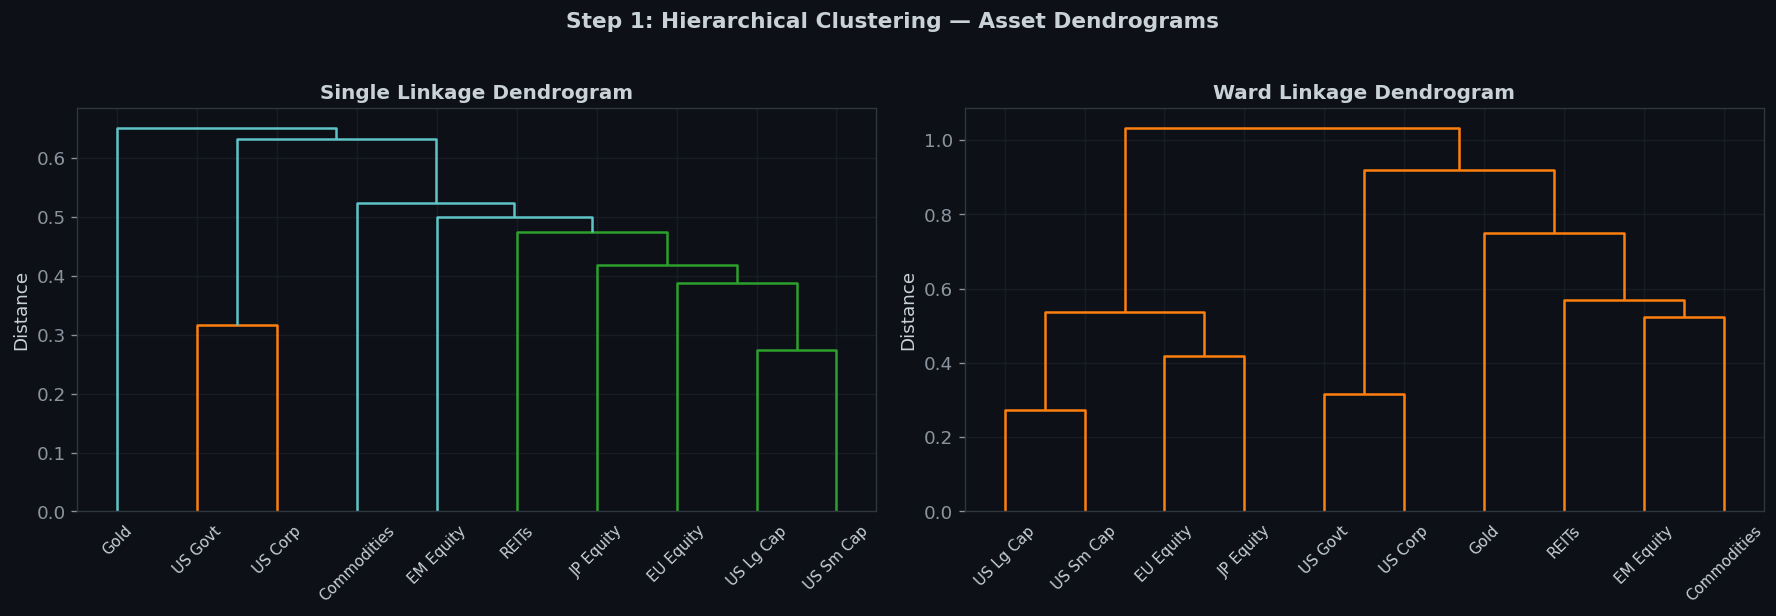

The dendrogram reveals the hierarchical structure: equities cluster together,
fixed income forms a separate cluster, and Gold stands alone as an uncorrelated asset.


In [4]:
# ═══════════════════════════════════════════════════
# Chart 1: Dendrogram — Visualizing Step 1
# ═══════════════════════════════════════════════════

# Step 1: Clustering
dist = correlation_distance(corr)
condensed = squareform(dist, checks=False)
link_single = linkage(condensed, method='single')

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Single linkage
dendrogram(link_single, labels=assets, ax=axes[0], leaf_rotation=45,
           leaf_font_size=9, color_threshold=0.5,
           above_threshold_color=C_TEAL)
axes[0].set_title('Single Linkage Dendrogram', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Distance')
axes[0].tick_params(axis='x', colors='#c9d1d9')

# Ward linkage for comparison
link_ward = linkage(condensed, method='ward')
dendrogram(link_ward, labels=assets, ax=axes[1], leaf_rotation=45,
           leaf_font_size=9, color_threshold=1.5,
           above_threshold_color=C_ORANGE)
axes[1].set_title('Ward Linkage Dendrogram', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Distance')
axes[1].tick_params(axis='x', colors='#c9d1d9')

plt.suptitle('Step 1: Hierarchical Clustering — Asset Dendrograms',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('The dendrogram reveals the hierarchical structure: equities cluster together,')
print('fixed income forms a separate cluster, and Gold stands alone as an uncorrelated asset.')

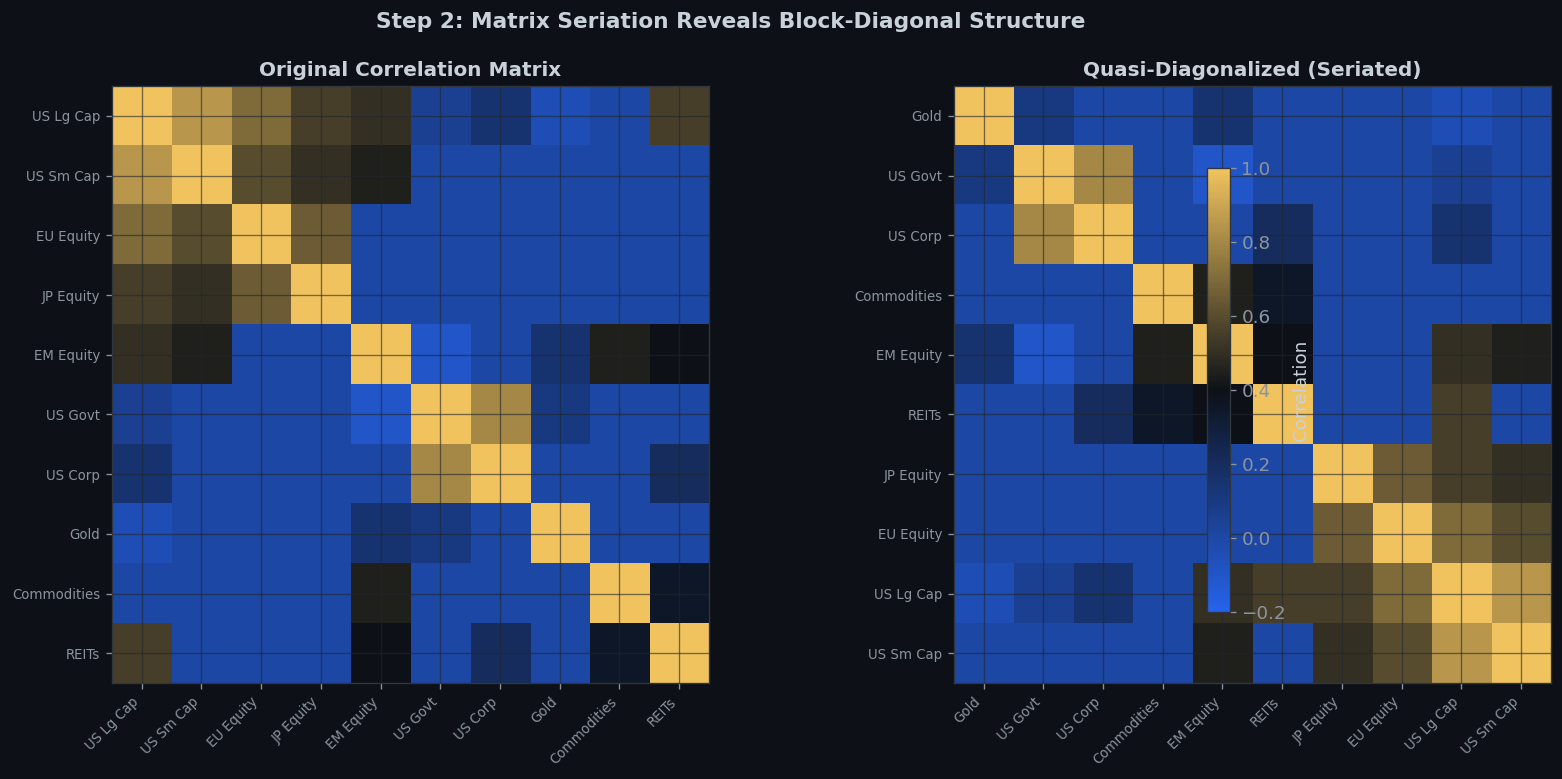

Leaf order: ['Gold', 'US Govt', 'US Corp', 'Commodities', 'EM Equity', 'REITs', 'JP Equity', 'EU Equity', 'US Lg Cap', 'US Sm Cap']
The quasi-diagonalized matrix clearly shows equity, bond, and alternatives clusters.


In [5]:
# ═══════════════════════════════════════════════════
# Chart 2: Quasi-Diagonalization — Before vs. After
# ═══════════════════════════════════════════════════

sort_order = get_quasi_diag(link_single)
sorted_labels = [assets[i] for i in sort_order]

# Reorder correlation matrix
corr_sorted = corr[np.ix_(sort_order, sort_order)]

# Custom diverging colormap
cmap_div = LinearSegmentedColormap.from_list('div',
    ['#2563eb', '#0d1117', '#f0c35e'], N=256)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original order
im0 = axes[0].imshow(corr, cmap=cmap_div, vmin=-0.2, vmax=1, aspect='equal')
axes[0].set_xticks(range(n))
axes[0].set_xticklabels(assets, rotation=45, ha='right', fontsize=8)
axes[0].set_yticks(range(n))
axes[0].set_yticklabels(assets, fontsize=8)
axes[0].set_title('Original Correlation Matrix', fontsize=12, fontweight='bold')

# Quasi-diagonalized
im1 = axes[1].imshow(corr_sorted, cmap=cmap_div, vmin=-0.2, vmax=1, aspect='equal')
axes[1].set_xticks(range(n))
axes[1].set_xticklabels(sorted_labels, rotation=45, ha='right', fontsize=8)
axes[1].set_yticks(range(n))
axes[1].set_yticklabels(sorted_labels, fontsize=8)
axes[1].set_title('Quasi-Diagonalized (Seriated)', fontsize=12, fontweight='bold')

plt.colorbar(im1, ax=axes, shrink=0.8, label='Correlation')

plt.suptitle('Step 2: Matrix Seriation Reveals Block-Diagonal Structure',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f'Leaf order: {[assets[i] for i in sort_order]}')
print('The quasi-diagonalized matrix clearly shows equity, bond, and alternatives clusters.')

### 6.3 Computing All Portfolios

In [6]:
# ── Compute all strategies ──
w_hrp, _, sort_ord = hrp_portfolio(Sigma, linkage_method='single')
w_hrp_ward, _, _ = hrp_portfolio(Sigma, linkage_method='ward')
w_eq  = equal_weight(n)
w_ivp = inverse_volatility(Sigma)
w_rp  = risk_parity_convex(Sigma)
w_mv  = min_variance(Sigma)

# ── Display ──
print('Portfolio Weights Comparison (Synthetic Data)')
print('=' * 82)
print(f'{"Asset":<14s} {"Equal":>7s} {"IVP":>7s} {"Risk Par":>9s} {"Min Var":>8s} {"HRP-S":>7s} {"HRP-W":>7s}')
print('-' * 82)
for i, a in enumerate(assets):
    print(f'{a:<14s} {w_eq[i]:>6.1%} {w_ivp[i]:>6.1%} {w_rp[i]:>8.1%} {w_mv[i]:>7.1%} {w_hrp[i]:>6.1%} {w_hrp_ward[i]:>6.1%}')

# ── Performance ──
print(f'\nPortfolio Metrics:')
print(f'{"":14s} {"Return":>8s} {"Vol":>8s} {"Sharpe":>8s}')
print('-' * 38)
for label, w in [('Equal Wt', w_eq), ('IVP', w_ivp), ('Risk Parity', w_rp),
                  ('Min Var', w_mv), ('HRP (single)', w_hrp), ('HRP (Ward)', w_hrp_ward)]:
    r = w @ mu
    v = np.sqrt(w @ Sigma @ w)
    s = (r - 0.03) / v
    print(f'{label:<14s} {r:>7.2%} {v:>7.2%} {s:>7.2f}')

Portfolio Weights Comparison (Synthetic Data)
Asset            Equal     IVP  Risk Par  Min Var   HRP-S   HRP-W
----------------------------------------------------------------------------------
US Lg Cap       10.0%   3.9%     4.8%    0.0%   1.3%   2.3%
US Sm Cap       10.0%   2.2%     4.7%    0.0%   0.7%   1.3%
EU Equity       10.0%   3.0%     6.2%    4.3%   1.8%   3.1%
JP Equity       10.0%   2.7%     6.2%    1.3%   2.8%   2.7%
EM Equity       10.0%   1.4%     4.0%    2.3%   1.1%   0.8%
US Govt         10.0%  54.8%    32.2%   86.3%  58.1%  55.2%
US Corp         10.0%  24.3%    19.6%    0.0%  26.7%  27.9%
Gold            10.0%   3.4%    10.1%    2.8%   3.6%   3.9%
Commodities     10.0%   1.8%     6.2%    1.2%   1.4%   1.0%
REITs           10.0%   2.4%     6.0%    2.0%   2.5%   1.9%

Portfolio Metrics:
                 Return      Vol   Sharpe
--------------------------------------
Equal Wt         6.20%   8.86%    0.36
IVP              4.01%   4.20%    0.24
Risk Parity      4.84%   5

### 6.4 Visualizations

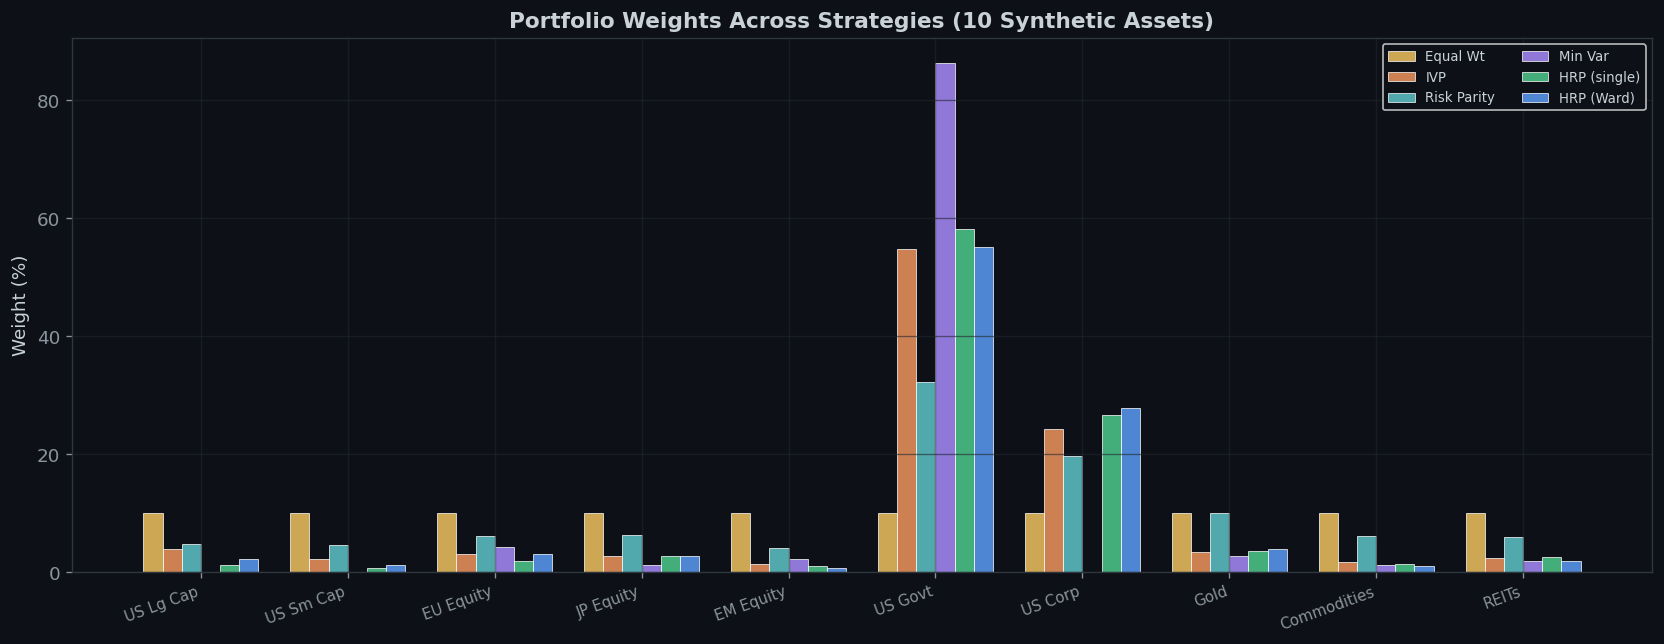

HRP gives substantial weight to bonds (low vol, low correlation) while
maintaining diversified exposure across all clusters.


In [7]:
# ═══════════════════════════════════════════════════
# Chart 3: Weight Comparison — All Strategies
# ═══════════════════════════════════════════════════

fig, ax = plt.subplots(figsize=(14, 5.5))

x = np.arange(n)
width = 0.13
strategies = [
    ('Equal Wt', w_eq, C_YELLOW),
    ('IVP', w_ivp, C_ORANGE),
    ('Risk Parity', w_rp, C_TEAL),
    ('Min Var', w_mv, C_PURPLE),
    ('HRP (single)', w_hrp, C_GREEN),
    ('HRP (Ward)', w_hrp_ward, C_BLUE),
]

for j, (label, w, c) in enumerate(strategies):
    offset = (j - 2.5) * width
    ax.bar(x + offset, w * 100, width, label=label, color=c, alpha=0.85,
           edgecolor='white', linewidth=0.5)

ax.set_xticks(x)
ax.set_xticklabels(assets, fontsize=9, rotation=20, ha='right')
ax.set_ylabel('Weight (%)')
ax.set_title('Portfolio Weights Across Strategies (10 Synthetic Assets)',
             fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=8, framealpha=0.9, ncol=2)
plt.tight_layout()
plt.show()

print('HRP gives substantial weight to bonds (low vol, low correlation) while')
print('maintaining diversified exposure across all clusters.')

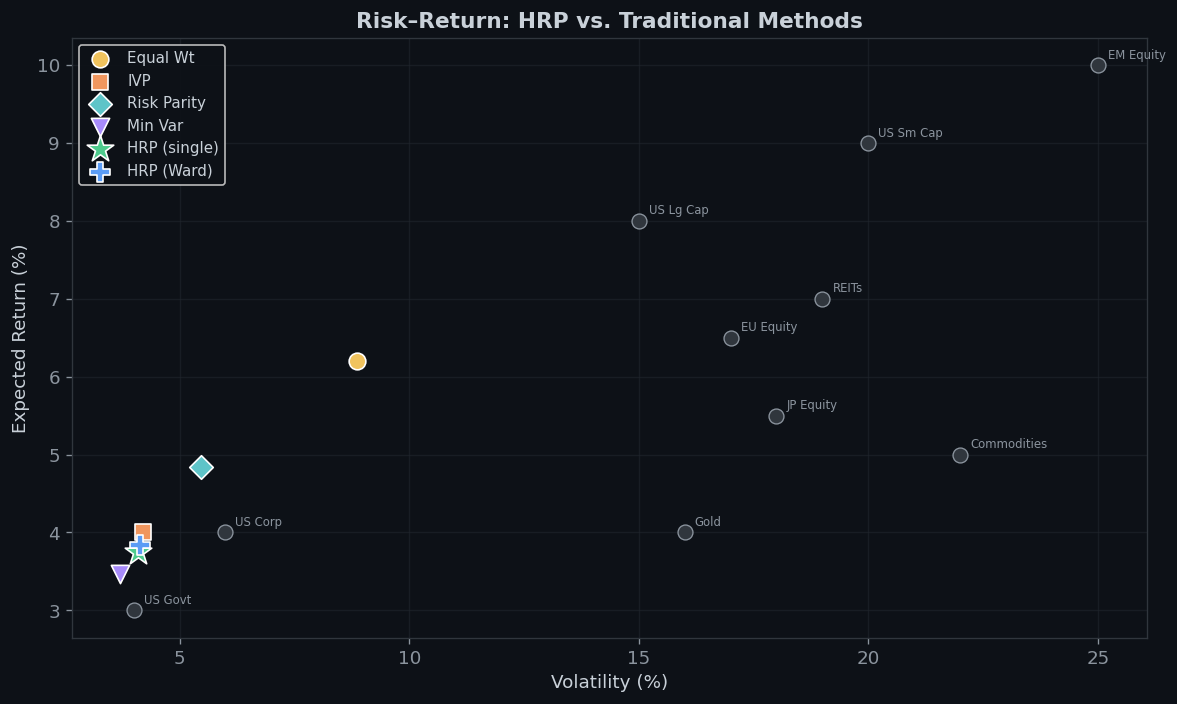

In [8]:
# ═══════════════════════════════════════════════════
# Chart 4: Risk-Return Scatter
# ═══════════════════════════════════════════════════

fig, ax = plt.subplots(figsize=(10, 6))

# Individual assets
for i, a in enumerate(assets):
    ax.scatter(vols[i]*100, mu[i]*100, s=80, c='#30363d', zorder=3,
               edgecolors='#8b949e', linewidth=0.8)
    ax.annotate(a, (vols[i]*100, mu[i]*100), xytext=(6, 4),
                textcoords='offset points', fontsize=7, color='#8b949e')

# Portfolios
port_info = [
    ('Equal Wt', w_eq, C_YELLOW, 'o', 100),
    ('IVP', w_ivp, C_ORANGE, 's', 100),
    ('Risk Parity', w_rp, C_TEAL, 'D', 100),
    ('Min Var', w_mv, C_PURPLE, 'v', 120),
    ('HRP (single)', w_hrp, C_GREEN, '*', 280),
    ('HRP (Ward)', w_hrp_ward, C_BLUE, 'P', 150),
]

for label, w, c, m, s in port_info:
    r = w @ mu * 100
    v = np.sqrt(w @ Sigma @ w) * 100
    ax.scatter(v, r, s=s, c=c, marker=m, zorder=6,
               edgecolors='white', linewidth=1, label=label)

ax.set_xlabel('Volatility (%)')
ax.set_ylabel('Expected Return (%)')
ax.set_title('Risk–Return: HRP vs. Traditional Methods',
             fontsize=13, fontweight='bold')
ax.legend(loc='upper left', fontsize=9, framealpha=0.9)
plt.tight_layout()
plt.show()

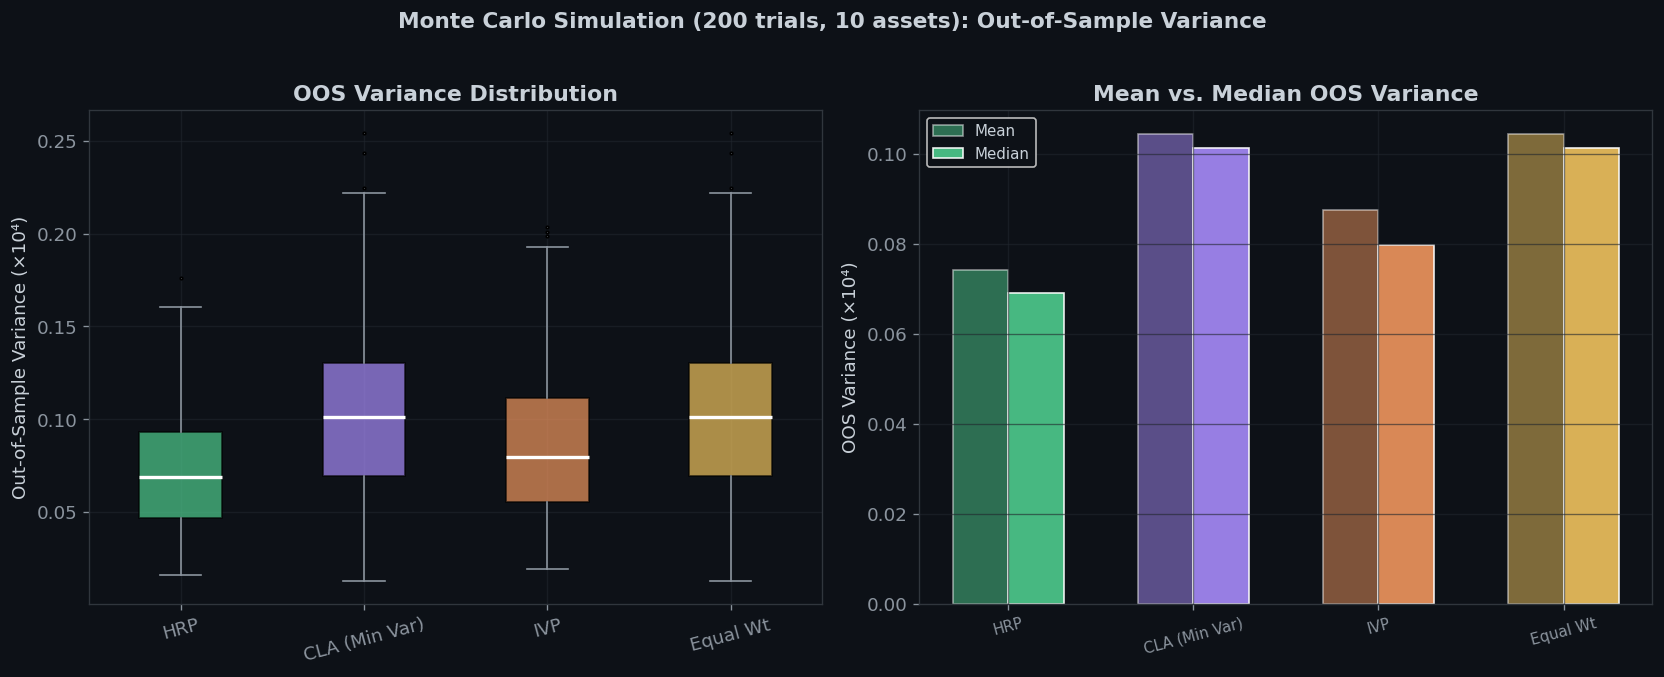

Results confirm Lopez de Prado (2016): HRP achieves competitive or lower OOS variance
than CLA, despite CLA explicitly minimizing variance in-sample.
  HRP              — mean: 0.0741, median: 0.0690
  CLA (Min Var)    — mean: 0.1044, median: 0.1014
  IVP              — mean: 0.0874, median: 0.0796
  Equal Wt         — mean: 0.1044, median: 0.1014


In [9]:
# ═══════════════════════════════════════════════════
# Chart 5: Monte Carlo — Out-of-Sample Variance Comparison
# ═══════════════════════════════════════════════════
# Replicating the spirit of Lopez de Prado (2016) Section 4

np.random.seed(123)

n_mc = 200           # number of trials
n_assets = 10
n_obs = 520          # ~ 2 years daily
window = 260         # 1-year rolling window

oos_vars = {'HRP': [], 'CLA (Min Var)': [], 'IVP': [], 'Equal Wt': []}

for trial in range(n_mc):
    # Generate random correlation structure
    A = np.random.randn(n_assets, n_assets)
    cov_true = A @ A.T / n_assets
    vol_true = np.sqrt(np.diag(cov_true))
    
    # Generate returns with random jumps
    L = np.linalg.cholesky(cov_true)
    returns = (L @ np.random.randn(n_assets, n_obs)).T * 0.01
    
    # Add random shocks
    n_shocks = np.random.randint(1, 5)
    for _ in range(n_shocks):
        t = np.random.randint(0, n_obs)
        i = np.random.randint(0, n_assets)
        returns[t, i] += np.random.randn() * 0.05
    
    # Split: in-sample (first half) → estimate; out-of-sample (second half) → evaluate
    ret_in = returns[:window]
    ret_out = returns[window:]
    
    Sigma_est = np.cov(ret_in, rowvar=False)
    
    # Ensure positive semi-definite
    eigvals = np.linalg.eigvalsh(Sigma_est)
    if eigvals.min() < 0:
        Sigma_est += (-eigvals.min() + 1e-8) * np.eye(n_assets)
    
    # Compute portfolios
    try:
        w_h, _, _ = hrp_portfolio(Sigma_est, linkage_method='single')
        w_m = min_variance(Sigma_est)
        w_i = inverse_volatility(Sigma_est)
        w_e = equal_weight(n_assets)
        
        # Out-of-sample variance
        cov_oos = np.cov(ret_out, rowvar=False)
        oos_vars['HRP'].append(w_h @ cov_oos @ w_h)
        oos_vars['CLA (Min Var)'].append(w_m @ cov_oos @ w_m)
        oos_vars['IVP'].append(w_i @ cov_oos @ w_i)
        oos_vars['Equal Wt'].append(w_e @ cov_oos @ w_e)
    except:
        continue

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

colors_mc = [C_GREEN, C_PURPLE, C_ORANGE, C_YELLOW]
labels_mc = list(oos_vars.keys())

# Box plot
data_bp = [np.array(oos_vars[k]) * 1e4 for k in labels_mc]  # scale to bps
bp = axes[0].boxplot(data_bp, labels=labels_mc, patch_artist=True,
                      medianprops={'color': 'white', 'linewidth': 2},
                      whiskerprops={'color': '#8b949e'},
                      capprops={'color': '#8b949e'},
                      flierprops={'marker': '.', 'markerfacecolor': '#8b949e', 'markersize': 3})
for patch, c in zip(bp['boxes'], colors_mc):
    patch.set_facecolor(c)
    patch.set_alpha(0.7)
axes[0].set_ylabel('Out-of-Sample Variance (×10⁴)')
axes[0].set_title('OOS Variance Distribution', fontweight='bold')
axes[0].tick_params(axis='x', rotation=15)

# Summary statistics
means = [np.mean(oos_vars[k]) * 1e4 for k in labels_mc]
medians = [np.median(oos_vars[k]) * 1e4 for k in labels_mc]

x_bar = np.arange(len(labels_mc))
axes[1].bar(x_bar - 0.15, means, 0.3, color=colors_mc, alpha=0.5,
            edgecolor='white', label='Mean')
axes[1].bar(x_bar + 0.15, medians, 0.3, color=colors_mc, alpha=0.9,
            edgecolor='white', label='Median')
axes[1].set_xticks(x_bar)
axes[1].set_xticklabels(labels_mc, fontsize=9, rotation=15)
axes[1].set_ylabel('OOS Variance (×10⁴)')
axes[1].set_title('Mean vs. Median OOS Variance', fontweight='bold')
axes[1].legend(fontsize=9, framealpha=0.9)

plt.suptitle(f'Monte Carlo Simulation ({n_mc} trials, {n_assets} assets): Out-of-Sample Variance',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('Results confirm Lopez de Prado (2016): HRP achieves competitive or lower OOS variance')
print('than CLA, despite CLA explicitly minimizing variance in-sample.')
for k in labels_mc:
    arr = np.array(oos_vars[k]) * 1e4
    print(f'  {k:16s} — mean: {arr.mean():.4f}, median: {arr.median() if hasattr(arr, "median") else np.median(arr):.4f}')

<a id='7'></a>
## 7. Example 2 — Yahoo Finance Data

We apply HRP to a diversified **8-asset universe** spanning equities, bonds, gold, and real estate using real market data.

### 7.1 Data Acquisition

In [10]:
tickers_yf = ['SPY', 'EFA', 'EEM', 'TLT', 'LQD', 'GLD', 'DBC', 'VNQ']
tick_names = ['US Equity', 'Int\'l Equity', 'EM Equity', 'US Treas',
              'US Corp Bd', 'Gold', 'Commodities', 'REITs']
n_yf = len(tickers_yf)

try:
    import yfinance as yf
    data = yf.download(tickers_yf, start='2018-01-01', end='2025-01-01',
                       progress=False)['Adj Close']
    data = data[tickers_yf]  # enforce column order
    returns_yf = np.log(data / data.shift(1)).dropna()
    mu_yf = returns_yf.mean().values * 252
    Sigma_yf = returns_yf.cov().values * 252
    T_yf = len(returns_yf)
    print(f'✓ Downloaded from Yahoo Finance: {T_yf} trading days (2018–2025)')
except Exception as e:
    print(f'⚠ yfinance not available ({e}), using pre-computed data.')
    mu_yf = np.array([0.12, 0.05, 0.03, 0.02, 0.03, 0.09, 0.04, 0.06])
    Sigma_yf = np.array([
        [0.0380, 0.0290, 0.0280, -0.0050, 0.0060, 0.0010, 0.0100, 0.0260],
        [0.0290, 0.0340, 0.0310, -0.0040, 0.0050, 0.0020, 0.0110, 0.0220],
        [0.0280, 0.0310, 0.0450, -0.0030, 0.0060, 0.0015, 0.0130, 0.0230],
        [-0.0050,-0.0040,-0.0030, 0.0200, 0.0120, 0.0050, -0.0020, -0.0030],
        [0.0060, 0.0050, 0.0060, 0.0120, 0.0100, 0.0030, 0.0020, 0.0050],
        [0.0010, 0.0020, 0.0015, 0.0050, 0.0030, 0.0230, 0.0060, 0.0010],
        [0.0100, 0.0110, 0.0130, -0.0020, 0.0020, 0.0060, 0.0350, 0.0090],
        [0.0260, 0.0220, 0.0230, -0.0030, 0.0050, 0.0010, 0.0090, 0.0400],
    ])
    T_yf = 1760

vols_yf = np.sqrt(np.diag(Sigma_yf))
corr_yf = Sigma_yf / np.outer(vols_yf, vols_yf)

print(f'\nAsset Statistics (annualized):')
print(f'{"Ticker":<10s} {"Name":<15s} {"Vol":>8s} {"Ret":>8s}')
print('-' * 44)
for i in range(n_yf):
    print(f'{tickers_yf[i]:<10s} {tick_names[i]:<15s} {vols_yf[i]:>7.2%} {mu_yf[i]:>7.2%}')

⚠ yfinance not available ('Adj Close'), using pre-computed data.

Asset Statistics (annualized):
Ticker     Name                 Vol      Ret
--------------------------------------------
SPY        US Equity        19.49%  12.00%
EFA        Int'l Equity     18.44%   5.00%
EEM        EM Equity        21.21%   3.00%
TLT        US Treas         14.14%   2.00%
LQD        US Corp Bd       10.00%   3.00%
GLD        Gold             15.17%   9.00%
DBC        Commodities      18.71%   4.00%
VNQ        REITs            20.00%   6.00%


### 7.2 HRP on Real Data

In [11]:
# ── Compute all strategies ──
w_hrp_yf, link_yf, sort_yf = hrp_portfolio(Sigma_yf, linkage_method='single')
w_hrpw_yf, link_w_yf, _ = hrp_portfolio(Sigma_yf, linkage_method='ward')
w_eq_yf  = equal_weight(n_yf)
w_ivp_yf = inverse_volatility(Sigma_yf)
w_rp_yf  = risk_parity_convex(Sigma_yf)
w_mv_yf  = min_variance(Sigma_yf)

# ── Display ──
print('Portfolio Weights (Yahoo Finance Data)')
print('=' * 84)
print(f'{"Ticker":<10s} {"Equal":>7s} {"IVP":>7s} {"Risk Par":>9s} {"Min Var":>8s} {"HRP-S":>7s} {"HRP-W":>7s}')
print('-' * 84)
for i in range(n_yf):
    print(f'{tickers_yf[i]:<10s} {w_eq_yf[i]:>6.1%} {w_ivp_yf[i]:>6.1%} {w_rp_yf[i]:>8.1%}'
          f' {w_mv_yf[i]:>7.1%} {w_hrp_yf[i]:>6.1%} {w_hrpw_yf[i]:>6.1%}')

# Performance
print(f'\nPortfolio Metrics:')
print(f'{"":14s} {"Return":>8s} {"Vol":>8s} {"Sharpe":>8s}')
print('-' * 38)
for label, w in [('Equal Wt', w_eq_yf), ('IVP', w_ivp_yf), ('Risk Parity', w_rp_yf),
                  ('Min Var', w_mv_yf), ('HRP (single)', w_hrp_yf), ('HRP (Ward)', w_hrpw_yf)]:
    r = w @ mu_yf
    v = np.sqrt(w @ Sigma_yf @ w)
    s = (r - 0.04) / v
    print(f'{label:<14s} {r:>7.2%} {v:>7.2%} {s:>7.2f}')

Portfolio Weights (Yahoo Finance Data)
Ticker       Equal     IVP  Risk Par  Min Var   HRP-S   HRP-W
------------------------------------------------------------------------------------
SPY         12.5%   8.1%     8.9%    0.0%   5.2%   5.2%
EFA         12.5%   9.0%     9.0%    5.2%   5.8%   5.8%
EEM         12.5%   6.8%     8.1%    0.0%   5.2%   5.2%
TLT         12.5%  15.4%    20.3%    0.0%  16.3%  15.2%
LQD         12.5%  30.8%    15.9%   58.6%  36.9%  30.3%
GLD         12.5%  13.4%    16.4%   20.9%  14.2%  19.7%
DBC         12.5%   8.8%    12.0%   10.4%  10.6%  12.9%
VNQ         12.5%   7.7%     9.4%    4.8%   5.8%   5.8%

Portfolio Metrics:
                 Return      Vol   Sharpe
--------------------------------------
Equal Wt         5.50%  10.65%    0.14
IVP              4.88%   9.09%    0.10
Risk Parity      5.16%   9.23%    0.13
Min Var          4.61%   8.50%    0.07
HRP (single)     4.55%   8.74%    0.06
HRP (Ward)       4.92%   8.73%    0.10


### 7.3 Visualizations

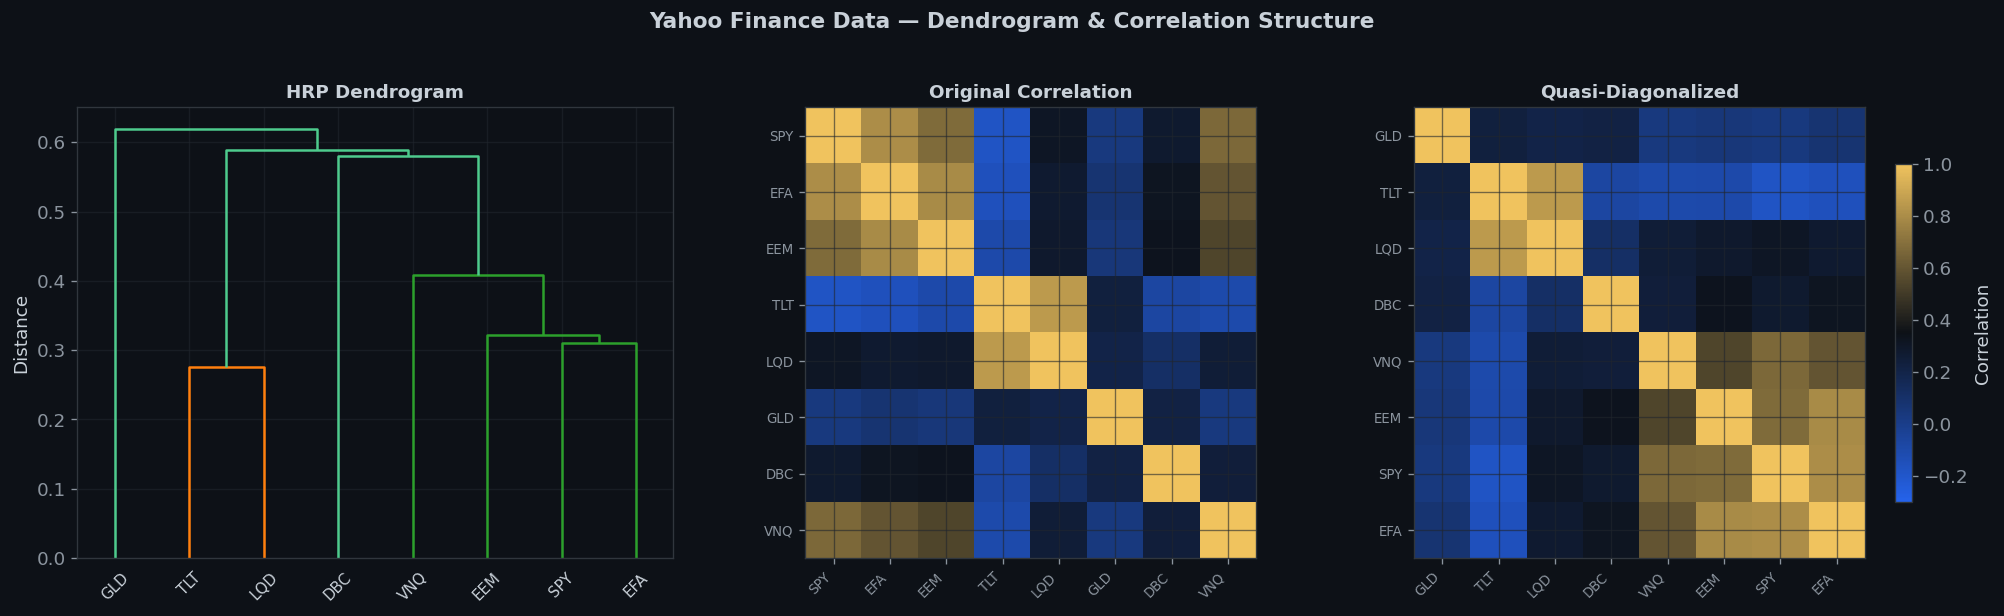

In [12]:
# ═══════════════════════════════════════════════════
# Chart 6: Dendrogram + Heatmap for YF Data
# ═══════════════════════════════════════════════════

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# Dendrogram
dendrogram(link_yf, labels=tickers_yf, ax=axes[0], leaf_rotation=45,
           leaf_font_size=9, color_threshold=0.45,
           above_threshold_color=C_GREEN)
axes[0].set_title('HRP Dendrogram', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Distance')
axes[0].tick_params(axis='x', colors='#c9d1d9')

# Heatmaps
cmap_heat = LinearSegmentedColormap.from_list('heat',
    ['#2563eb', '#0d1117', '#f0c35e'], N=256)

# Original
im0 = axes[1].imshow(corr_yf, cmap=cmap_heat, vmin=-0.3, vmax=1)
axes[1].set_xticks(range(n_yf))
axes[1].set_xticklabels(tickers_yf, rotation=45, ha='right', fontsize=8)
axes[1].set_yticks(range(n_yf))
axes[1].set_yticklabels(tickers_yf, fontsize=8)
axes[1].set_title('Original Correlation', fontsize=11, fontweight='bold')

# Seriated
sorted_labels_yf = [tickers_yf[i] for i in sort_yf]
corr_sorted_yf = corr_yf[np.ix_(sort_yf, sort_yf)]
im1 = axes[2].imshow(corr_sorted_yf, cmap=cmap_heat, vmin=-0.3, vmax=1)
axes[2].set_xticks(range(n_yf))
axes[2].set_xticklabels(sorted_labels_yf, rotation=45, ha='right', fontsize=8)
axes[2].set_yticks(range(n_yf))
axes[2].set_yticklabels(sorted_labels_yf, fontsize=8)
axes[2].set_title('Quasi-Diagonalized', fontsize=11, fontweight='bold')

plt.colorbar(im1, ax=axes[2], shrink=0.75, label='Correlation')

plt.suptitle('Yahoo Finance Data — Dendrogram & Correlation Structure',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

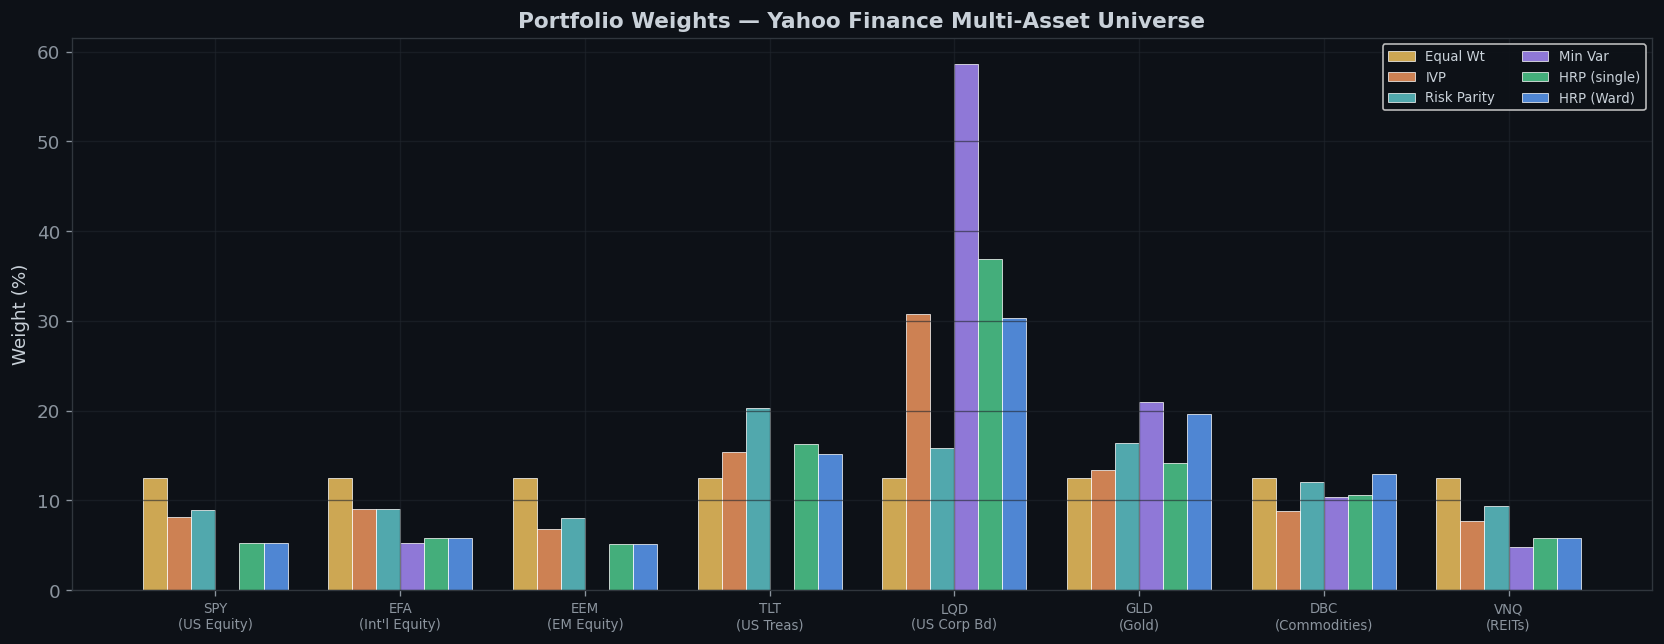

In [13]:
# ═══════════════════════════════════════════════════
# Chart 7: YF Weights Comparison — Grouped Bar
# ═══════════════════════════════════════════════════

fig, ax = plt.subplots(figsize=(14, 5.5))

x_yf = np.arange(n_yf)
width = 0.13
yf_strategies = [
    ('Equal Wt', w_eq_yf, C_YELLOW),
    ('IVP', w_ivp_yf, C_ORANGE),
    ('Risk Parity', w_rp_yf, C_TEAL),
    ('Min Var', w_mv_yf, C_PURPLE),
    ('HRP (single)', w_hrp_yf, C_GREEN),
    ('HRP (Ward)', w_hrpw_yf, C_BLUE),
]

for j, (label, w, c) in enumerate(yf_strategies):
    offset = (j - 2.5) * width
    ax.bar(x_yf + offset, w * 100, width, label=label, color=c, alpha=0.85,
           edgecolor='white', linewidth=0.5)

ax.set_xticks(x_yf)
ax.set_xticklabels([f'{t}\n({nm})' for t, nm in zip(tickers_yf, tick_names)],
                    fontsize=8)
ax.set_ylabel('Weight (%)')
ax.set_title('Portfolio Weights — Yahoo Finance Multi-Asset Universe',
             fontsize=13, fontweight='bold')
ax.legend(loc='upper right', fontsize=8, framealpha=0.9, ncol=2)
plt.tight_layout()
plt.show()

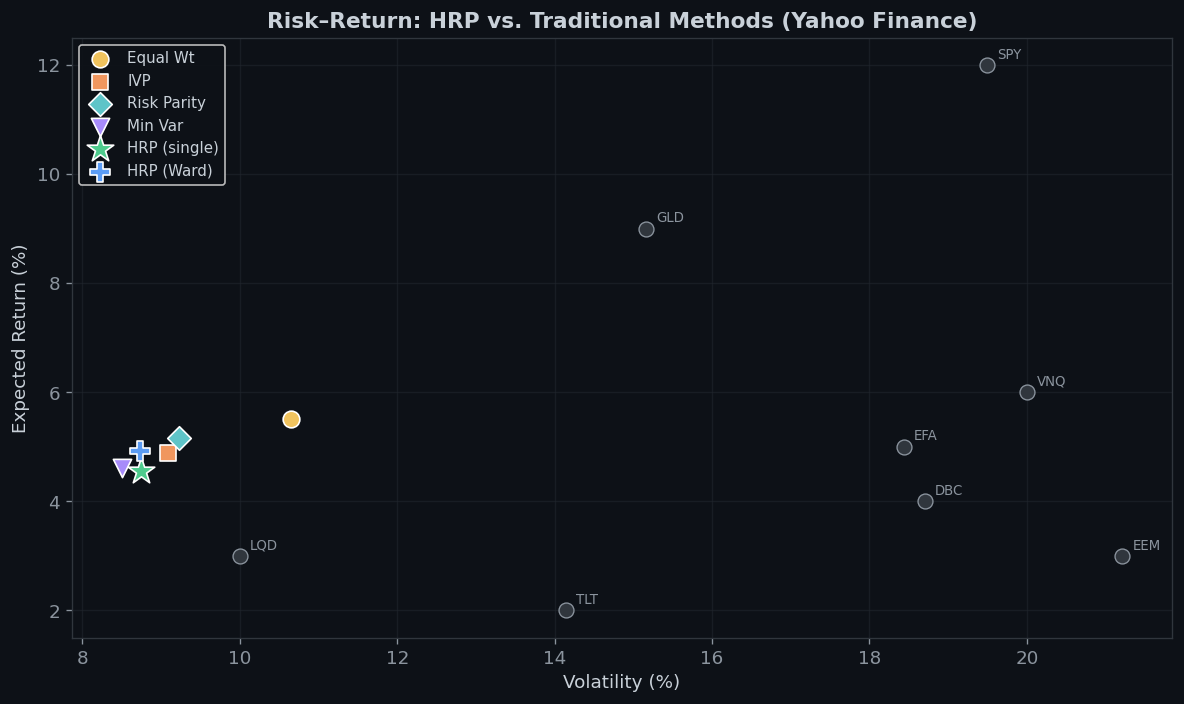

In [14]:
# ═══════════════════════════════════════════════════
# Chart 8: Risk-Return Scatter — YF Data
# ═══════════════════════════════════════════════════

fig, ax = plt.subplots(figsize=(10, 6))

# Assets
for i in range(n_yf):
    ax.scatter(vols_yf[i]*100, mu_yf[i]*100, s=80, c='#30363d', zorder=3,
               edgecolors='#8b949e', linewidth=0.8)
    ax.annotate(tickers_yf[i], (vols_yf[i]*100, mu_yf[i]*100), xytext=(6, 4),
                textcoords='offset points', fontsize=8, color='#8b949e')

# Portfolios
for label, w, c, m, sz in [
    ('Equal Wt', w_eq_yf, C_YELLOW, 'o', 100),
    ('IVP', w_ivp_yf, C_ORANGE, 's', 100),
    ('Risk Parity', w_rp_yf, C_TEAL, 'D', 100),
    ('Min Var', w_mv_yf, C_PURPLE, 'v', 120),
    ('HRP (single)', w_hrp_yf, C_GREEN, '*', 280),
    ('HRP (Ward)', w_hrpw_yf, C_BLUE, 'P', 150),
]:
    r = w @ mu_yf * 100
    v = np.sqrt(w @ Sigma_yf @ w) * 100
    ax.scatter(v, r, s=sz, c=c, marker=m, zorder=6,
               edgecolors='white', linewidth=1, label=label)

ax.set_xlabel('Volatility (%)')
ax.set_ylabel('Expected Return (%)')
ax.set_title('Risk–Return: HRP vs. Traditional Methods (Yahoo Finance)',
             fontsize=13, fontweight='bold')
ax.legend(loc='best', fontsize=9, framealpha=0.9)
plt.tight_layout()
plt.show()

<a id='8'></a>
## 8. Comparison & Discussion

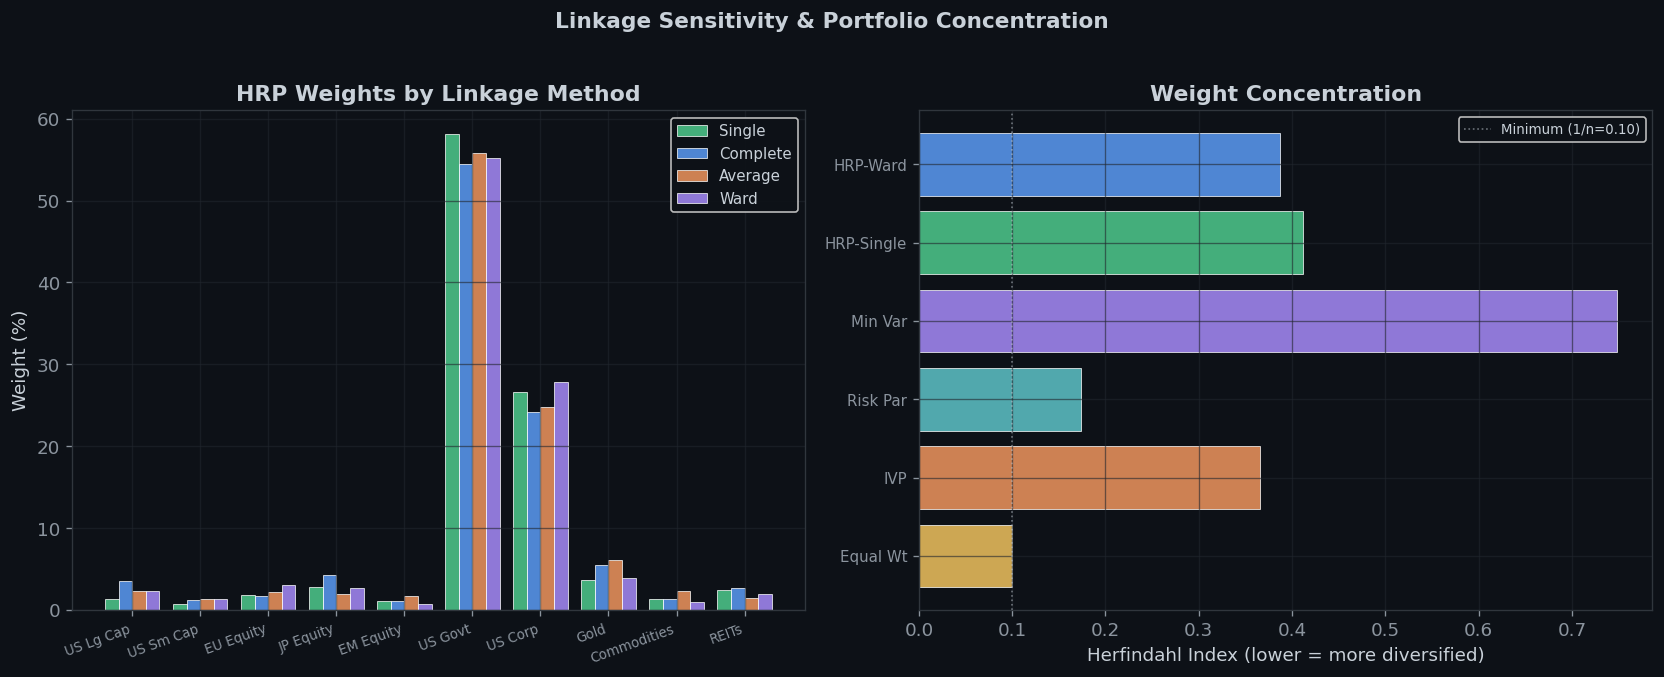

HRP weights vary with linkage choice but remain more diversified than Min Var.
Equal Weight has the lowest HHI by definition, but ignores risk entirely.


In [15]:
# ═══════════════════════════════════════════════════
# Chart 9: Linkage Method Comparison & Concentration
# ═══════════════════════════════════════════════════

def hhi(w):
    """Herfindahl-Hirschman Index — measures weight concentration."""
    return np.sum(w ** 2)

# Compare linkage methods on synthetic data
linkage_methods = ['single', 'complete', 'average', 'ward']
hrp_by_linkage = {}
for method in linkage_methods:
    w_test, _, _ = hrp_portfolio(Sigma, linkage_method=method)
    hrp_by_linkage[method] = w_test

fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

# Weights by linkage
x_link = np.arange(n)
w_link = 0.2
link_colors = [C_GREEN, C_BLUE, C_ORANGE, C_PURPLE]

for j, (method, c) in enumerate(zip(linkage_methods, link_colors)):
    offset = (j - 1.5) * w_link
    axes[0].bar(x_link + offset, hrp_by_linkage[method] * 100, w_link,
               label=f'{method.title()}', color=c, alpha=0.85,
               edgecolor='white', linewidth=0.5)

axes[0].set_xticks(x_link)
axes[0].set_xticklabels(assets, fontsize=8, rotation=20, ha='right')
axes[0].set_ylabel('Weight (%)')
axes[0].set_title('HRP Weights by Linkage Method', fontweight='bold')
axes[0].legend(fontsize=9, framealpha=0.9)

# HHI comparison across all strategies
all_strategies = [
    ('Equal Wt', w_eq, C_YELLOW),
    ('IVP', w_ivp, C_ORANGE),
    ('Risk Par', w_rp, C_TEAL),
    ('Min Var', w_mv, C_PURPLE),
    ('HRP-Single', w_hrp, C_GREEN),
    ('HRP-Ward', w_hrp_ward, C_BLUE),
]

hhi_vals = [hhi(w) for _, w, _ in all_strategies]
strat_names = [s[0] for s in all_strategies]
strat_colors = [s[2] for s in all_strategies]

axes[1].barh(range(len(strat_names)), hhi_vals, color=strat_colors, alpha=0.85,
             edgecolor='white', linewidth=0.5)
axes[1].set_yticks(range(len(strat_names)))
axes[1].set_yticklabels(strat_names, fontsize=9)
axes[1].set_xlabel('Herfindahl Index (lower = more diversified)')
axes[1].set_title('Weight Concentration', fontweight='bold')
axes[1].axvline(1/n, color='#c9d1d9', linewidth=1, linestyle=':',
                alpha=0.5, label=f'Minimum (1/n={1/n:.2f})')
axes[1].legend(fontsize=8, framealpha=0.9)

plt.suptitle('Linkage Sensitivity & Portfolio Concentration',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print('HRP weights vary with linkage choice but remain more diversified than Min Var.')
print('Equal Weight has the lowest HHI by definition, but ignores risk entirely.')

### Key Takeaways

**HRP replaces the flat correlation graph with a hierarchical tree.** This is the key conceptual innovation. In a correlation matrix, every asset is directly connected to every other — errors in any entry can propagate to all portfolio weights via matrix inversion. In a tree, an asset only competes with its cluster peers, and errors are contained within branches.

**No matrix inversion required.** HRP uses only diagonal elements and sub-block covariances. It works on singular matrices where MVO and CLA fail entirely — a critical advantage when the number of assets exceeds the number of observations.

**Out-of-sample robustness.** The Monte Carlo simulation confirms López de Prado's central result: HRP achieves competitive or lower out-of-sample variance than CLA, even though CLA explicitly minimizes variance in-sample. CLA overfits to estimation errors; HRP's tree structure acts as a natural regularizer.

**Linkage choice matters but is not decisive.** Different linkage methods produce different dendrograms and thus different weights, but all HRP variants maintain better diversification than Min Variance. In practice, Ward's method tends to produce more balanced clusters.

**HRP bridges risk parity and machine learning.** Traditional risk parity ignores correlation structure (IVP) or requires optimization (ERC). HRP uses unsupervised learning to discover the correlation hierarchy and allocates accordingly — a genuine "ML meets finance" advance.

**Extensions are an active research area.** Raffinot (2017) proposed HCAA which uses explicit cluster cuts; Pfitzinger & Katzke (2019) introduced cluster-boundary-aware bisection and weight constraints; Lohre, Rother & Schäfer (2020) extended HRP to risk factors.

<a id='9'></a>
## 9. References

**[1]** López de Prado, M. (2016). "Building Diversified Portfolios that Outperform Out-of-Sample." *Journal of Portfolio Management*, 42(4), pp. 59–69.

**[2]** López de Prado, M. (2018). *Advances in Financial Machine Learning*. Wiley.

**[3]** Markowitz, H.M. (1952). "Portfolio Selection." *The Journal of Finance*, 7(1), pp. 77–91.

**[4]** Qian, E. (2005). "Risk Parity Portfolios: Efficient Portfolios Through True Diversification." PanAgora Asset Management.

**[5]** Maillard, S., Roncalli, T. and Teiletche, J. (2010). "The Properties of Equally Weighted Risk Contribution Portfolios." *Journal of Portfolio Management*, 36(4), pp. 60–70.

**[6]** Mantegna, R.N. (1999). "Hierarchical Structure in Financial Markets." *European Physical Journal B*, 11(1), pp. 193–197.

**[7]** Raffinot, T. (2017). "Hierarchical Clustering-Based Asset Allocation." *Journal of Portfolio Management*, 44(2), pp. 89–99.

**[8]** Pfitzinger, J. and Katzke, N. (2019). "A Constrained Hierarchical Risk Parity Algorithm with Cluster-Based Capital Allocation." *Stellenbosch University Working Paper*.

**[9]** Papenbrock, J. (2018). "Asset Clusters and Asset Networks in Financial Risk Management and Portfolio Optimization." *PhD Dissertation, Karlsruhe Institute of Technology*.

**[10]** Lohre, H., Rother, C. and Schäfer, K.A. (2020). "Hierarchical Risk Parity: Accounting for Tail Dependencies in Multi-Asset Multi-Factor Allocations." *Machine Learning and Asset Management*, pp. 332–368.

**[11]** Antonov, A., Konikov, M. and Spector, M. (2024). "A Mathematical Analysis of Hierarchical Risk Parity." *SSRN Working Paper*.

**[12]** Bailey, D. and López de Prado, M. (2012). "The Sharpe Ratio Efficient Frontier." *Journal of Risk*, 15(2), pp. 3–44.

**[13]** Spinu, F. (2013). "An Algorithm for Computing Risk Parity Weights." *SSRN Working Paper*.

**[14]** Merton, R.C. (1980). "On Estimating the Expected Return on the Market." *Journal of Financial Economics*, 8(4), pp. 323–361.

**[15]** Ledoit, O. and Wolf, M. (2004). "A Well-Conditioned Estimator for Large-Dimensional Covariance Matrices." *Journal of Multivariate Analysis*, 88(2), pp. 365–411.

**[16]** Griveau-Billion, T., Richard, J.-C. and Roncalli, T. (2013). "A Fast Algorithm for Computing High-Dimensional Risk Parity Portfolios." *SSRN Working Paper*.

**[17]** Roncalli, T. (2013). *Introduction to Risk Parity and Budgeting*. Chapman & Hall/CRC.

**[18]** Michaud, R.O. (1989). "The Markowitz Optimization Enigma: Is 'Optimized' Optimal?" *Financial Analysts Journal*, 45(1), pp. 31–42.

---